# Drive

In [63]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [64]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [65]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [67]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [87]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [88]:
# Building our data frame 
df = pd.DataFrame()

for i in range(0, 36):
  temp_df = pd.DataFrame(X_train[:, i, :])
  temp_df["user_id"] = i
  temp_df["label"] = y_train
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"ch_0", 1:"ch_1", 2:"ch_2", 3:"ch_3", 4:"ch_4", 5:"ch_5", })
print(df.shape)
df.head()

(87444, 8)


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
0,17.5970,8.17130,-1.7842,-19.7060,-9.7135,-61.887,0,0
1,2.4209,-0.56039,23.6540,-3.8171,1.3721,8.251,0,0
2,39.6880,701.29000,3003.8000,34.8060,65.0360,77.808,0,0
3,1.6554,-1.94840,14.9890,-4.5047,-1.9535,16.397,0,0
4,-15.1390,5.36330,9.6577,-4.3281,-5.4659,22.605,0,0


In [89]:
# Split over users
df_train = df[df['user_id'] <= 31]
df_test = df[df['user_id'] > 31]
df_train.shape, df_test.shape

((77728, 8), (9716, 8))

In [90]:
# Add a date to use the seasonal_decompose module which requires a date for the points
df_train['date'] = pd.date_range(start='1/1/1900', periods=len(df_train))
# Convert daily column from just string to DateTime
df_train['date'] = pd.to_datetime(df_train['date'])
# Set the column 'Date' as index 
df_train = df_train.set_index('date')
# Specify datetime frequency
df_train = df_train.asfreq('D')
print(df_train.shape)
df_train.head()

(77728, 8)


<ipython-input-90-54da3076493e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = pd.date_range(start='1/1/1900', periods=len(df_train))
<ipython-input-90-54da3076493e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = pd.to_datetime(df_train['date'])


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
date,,,,,,,,
1900-01-01,17.5970,8.17130,-1.7842,-19.7060,-9.7135,-61.887,0,0
1900-01-02,2.4209,-0.56039,23.6540,-3.8171,1.3721,8.251,0,0
1900-01-03,39.6880,701.29000,3003.8000,34.8060,65.0360,77.808,0,0
1900-01-04,1.6554,-1.94840,14.9890,-4.5047,-1.9535,16.397,0,0
1900-01-05,-15.1390,5.36330,9.6577,-4.3281,-5.4659,22.605,0,0


In [91]:
# Add a date to use the seasonal_decompose module which requires a date for the points
df_test['date'] = pd.date_range(start='1/1/1900', periods=len(df_test))
# Convert daily column from just string to DateTime
df_test['date'] = pd.to_datetime(df_test['date'])
# Set the column 'Date' as index 
df_test = df_test.set_index('date')
# Specify datetime frequency
df_test = df_test.asfreq('D')
print(df_test.shape)
df_test.head()

(9716, 8)


<ipython-input-91-747bd8fa4204>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['date'] = pd.date_range(start='1/1/1900', periods=len(df_test))
<ipython-input-91-747bd8fa4204>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['date'] = pd.to_datetime(df_test['date'])


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
date,,,,,,,,
1900-01-01,117.420,348.0200,779.5300,-133.87000,-29.4610,40.7770,32,0
1900-01-02,-16.928,-5.8461,6.0301,0.43744,-1.0538,-4.9386,32,0
1900-01-03,29.838,12.5340,-13.0960,16.83000,30.0410,14.3020,32,0
1900-01-04,10.246,1.8267,-17.2090,2.19660,1.6058,61.8500,32,0
1900-01-05,-14.384,121.5500,296.8700,589.09000,9.3048,186.5800,32,0


In [92]:
y_df_train = pd.DataFrame()
y_df_train['label'] = df_train['label'].values
y_df_train['user_id'] = df_train['user_id'].values
print(y_df_train)

y_df_test = pd.DataFrame()
y_df_test['label'] = df_test['label'].values
y_df_test['user_id'] = df_test['user_id'].values
print(y_df_test)

       label  user_id
0          0        0
1          0        0
2          0        0
3          0        0
4          0        0
...      ...      ...
77723     11       31
77724     11       31
77725     11       31
77726     11       31
77727     11       31

[77728 rows x 2 columns]
      label  user_id
0         0       32
1         0       32
2         0       32
3         0       32
4         0       32
...     ...      ...
9711     11       35
9712     11       35
9713     11       35
9714     11       35
9715     11       35

[9716 rows x 2 columns]


In [93]:
df_train = df_train.rolling(5).mean()
df_test = df_test.rolling(5).mean()

In [94]:
df_train['label'] = y_df_train['label'].values
df_train['user_id'] = y_df_train['user_id'].values

df_test['label'] = y_df_test['label'].values
df_test['user_id'] = y_df_test['user_id'].values

In [96]:
print(df_train)
print(df_test)

                ch_0        ch_1        ch_2       ch_3       ch_4      ch_5  \
date                                                                           
1900-01-01       NaN         NaN         NaN        NaN        NaN       NaN   
1900-01-02       NaN         NaN         NaN        NaN        NaN       NaN   
1900-01-03       NaN         NaN         NaN        NaN        NaN       NaN   
1900-01-04       NaN         NaN         NaN        NaN        NaN       NaN   
1900-01-05   9.24446  142.463162  610.063300   0.490020   9.855040  12.63480   
...              ...         ...         ...        ...        ...       ...   
2112-10-19  13.70374   27.256510   37.986484  85.640876  78.444914  54.71822   
2112-10-20  12.33192   27.783710   38.772384  88.488976  82.570734  50.71878   
2112-10-21  12.96386   27.915380   40.006380  90.079040  86.528400  55.34558   
2112-10-22   0.76008    4.091180   16.209380  51.617640  56.293400   8.09958   
2112-10-23   0.77828    4.265080   18.24

In [97]:
# Apply MinMaxScaler to the useful features
scale_columns = ['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']
scaler = StandardScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [98]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)
df_train.head()

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
date,,,,,,,,
1900-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1900-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1900-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1900-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1900-01-05,0.000966,0.366984,1.970449,-0.106598,-0.078257,-0.053858,0,0


In [99]:
df_test.head()

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
date,,,,,,,,
1900-01-01,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,32,0
1900-01-02,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,32,0
1900-01-03,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,32,0
1900-01-04,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,32,0
1900-01-05,0.170937,0.228237,0.621589,0.222247,-0.10651,0.098754,32,0


In [100]:
window = 36
stride = 9

In [101]:
def build_sequences(df, window=36, stride=6):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for l in df['label'].unique():
        # Take only meaningful features
        temp = df[df['label'] == l][['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']].values
        # Save the label
        label = df[df['label'] == l]['label'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [102]:
X_train, y_train = build_sequences(df_train, window, stride)
X_test, y_test = build_sequences(df_test, window, stride)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8632, 36, 6), (8632,), (1068, 36, 6), (1068,))

In [103]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8632, 36, 6), (8632, 12), (1068, 36, 6), (1068, 12))

In [104]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [105]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(lstm)

    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)

    lstm = tfkl.GlobalAveragePooling1D()(attention)

    dropout = tfkl.Dropout(.4, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [106]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 36, 256)          394240    
 nal)                                                            
                                                                 
 seq_self_attention_2 (SeqSe  (None, 36, 256)          16449     
 lfAttention)                                                    
                                                                 
 global_average_pooling1d_2   (None, 256)              0         
 (GlobalAveragePooling1D)                                    

In [107]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
61/61 [==============================] - 57s 762ms/step - loss: 1.6257 - accuracy: 0.4396 - val_loss: 3.9734 - val_accuracy: 0.3507 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 42s 690ms/step - loss: 1.0007 - accuracy: 0.6416 - val_loss: 4.8065 - val_accuracy: 0.3981 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 44s 729ms/step - loss: 0.8458 - accuracy: 0.7030 - val_loss: 5.5009 - val_accuracy: 0.3970 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 42s 688ms/step - loss: 0.7814 - accuracy: 0.7264 - val_loss: 5.6102 - val_accuracy: 0.4005 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 43s 709ms/step - loss: 0.7300 - accuracy: 0.7402 - val_loss: 6.2398 - val_accuracy: 0.4190 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 43s 698ms/step - loss: 0.7000 - accuracy: 0.7461 - val_loss: 6.6878 - val_accuracy: 0.4039 - lr: 0.0010
Epoch 7/200
61/61 [==============================] - 43s 7

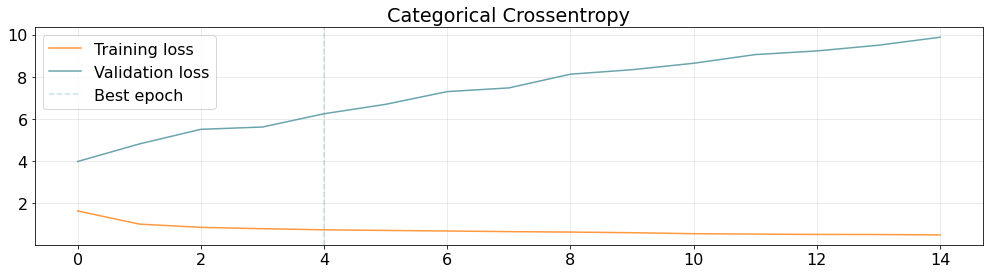

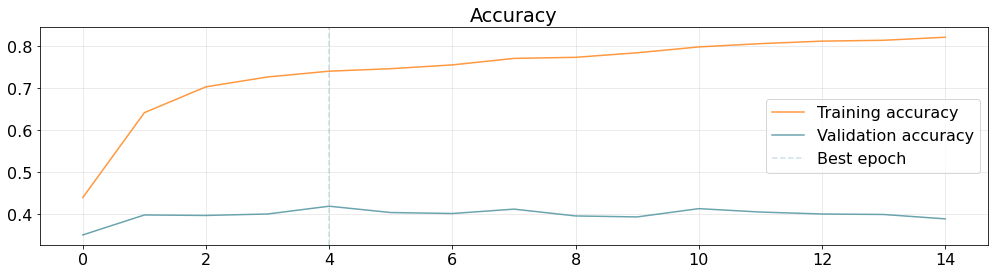

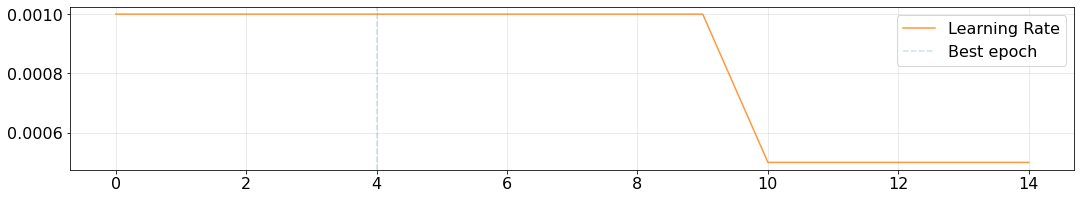

In [108]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [109]:
model.save('BiLSTM/attuation_rolling')
# model = tfk.models.load_model('BiLSTM')

In [110]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

34/34 [==============================] - 5s 93ms/step


(1068, 12)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7041
Precision: 0.4858
Recall: 0.507
F1: 0.4888


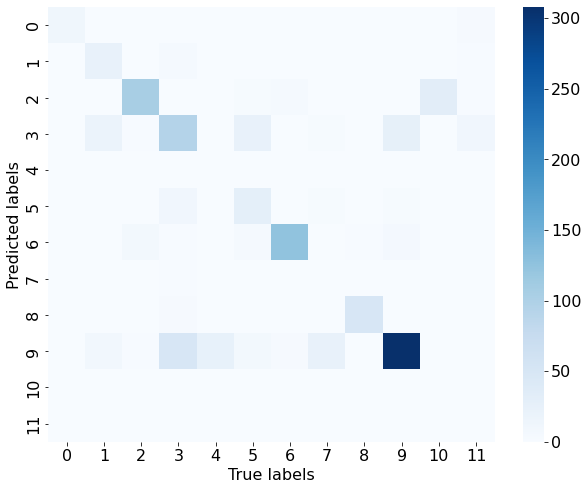

In [111]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()